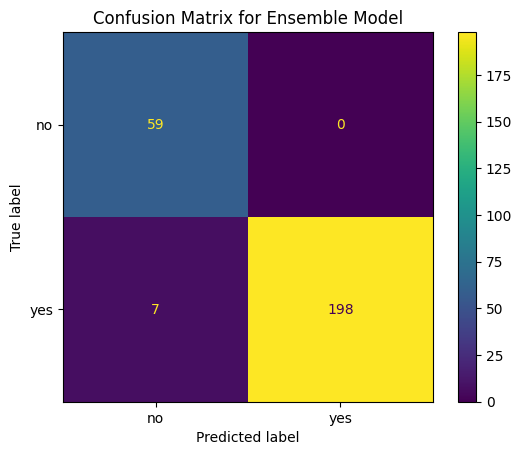

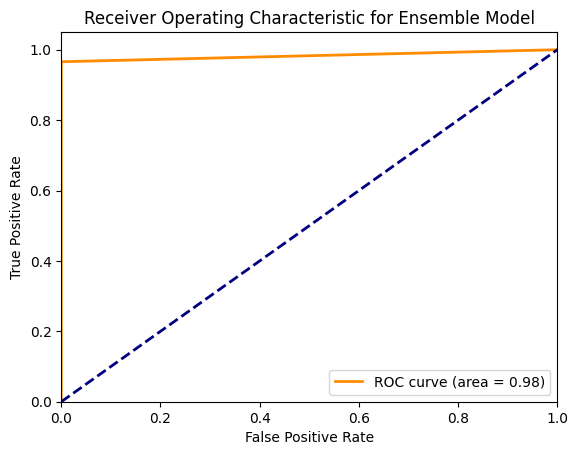

Naive Bayes: Accuracy = 97.3%
Decision Tree: Accuracy = 97.3%
Support Vector Machine: Accuracy = 94.7%
Random Forest: Accuracy = 97.0%
Ensemble: Accuracy = 97.3%

Best Model: Naive Bayes with Accuracy = 97.3%

Precision: 1.00, Recall: 0.97, F1-Score: 0.98, MCC: 0.93


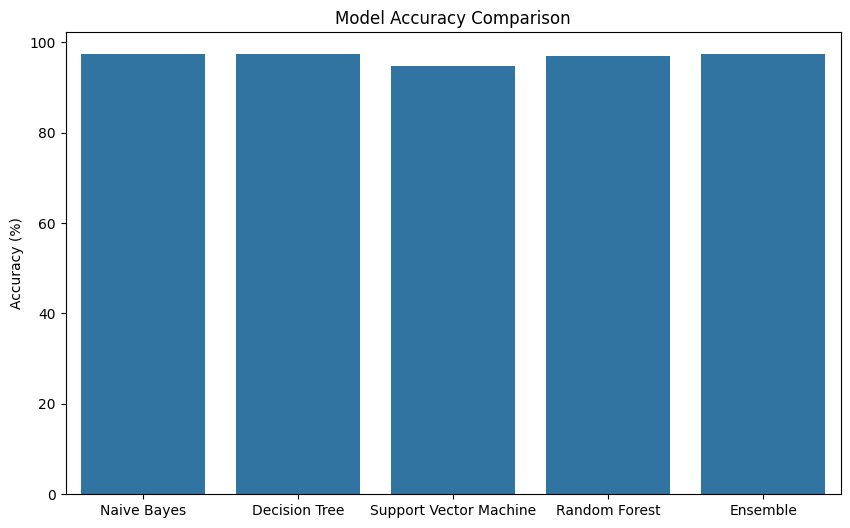

expenditure    0.957828
active         0.013334
age            0.009142
reports        0.008707
income         0.005955
share          0.003623
selfemp_yes    0.001412
dependents     0.000000
months         0.000000
majorcards     0.000000
owner_yes      0.000000
dtype: float64


In [ ]:
# Import necessary libraries
#!pip install shap # Install the missing 'shap' package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             matthews_corrcoef, confusion_matrix, roc_curve, auc) # Removed plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
import shap
from sklearn.metrics import ConfusionMatrixDisplay # Import ConfusionMatrixDisplay

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/data.csv')

# Feature and label separation
X = df.drop('card', axis=1)  # Assuming 'card' is the target variable
y = df['card']

# One-hot encoding for categorical variables
X = pd.get_dummies(X, drop_first=True)

# Train-test split with stratification to keep class balance in both sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Handle missing values by filling NaN with zeros
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handle class imbalance using SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Dictionary to store model accuracies
results = {}

# Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train_res, y_train_res)
y_pred_gnb = gnb.predict(X_test_scaled)
acc_nb = accuracy_score(y_test, y_pred_gnb) * 100
results['Naive Bayes'] = acc_nb

# Decision Tree Classifier with Hyperparameter Tuning
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 10, 20]
}
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
grid_search.fit(X_train_res, y_train_res)
best_dtc = grid_search.best_estimator_
y_pred_dtc = best_dtc.predict(X_test_scaled)
acc_dt = accuracy_score(y_test, y_pred_dtc) * 100
results['Decision Tree'] = acc_dt

# Support Vector Machine Classifier with Hyperparameter Tuning
svm_params = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}
svm_grid = GridSearchCV(SVC(random_state=42), svm_params, cv=5)
svm_grid.fit(X_train_res, y_train_res)
best_svm = svm_grid.best_estimator_
y_pred_svm = best_svm.predict(X_test_scaled)
acc_svm = accuracy_score(y_test, y_pred_svm) * 100
results['Support Vector Machine'] = acc_svm

# Random Forest Classifier for comparison
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train_res, y_train_res)
y_pred_rfc = rfc.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rfc) * 100
results['Random Forest'] = acc_rf

# Ensemble Voting Classifier
ensemble = VotingClassifier(estimators=[
    ('gnb', gnb), ('dtc', best_dtc), ('svm', best_svm)], voting='hard')
ensemble.fit(X_train_res, y_train_res)
y_pred_ensemble = ensemble.predict(X_test_scaled)
acc_ensemble = accuracy_score(y_test, y_pred_ensemble) * 100
results['Ensemble'] = acc_ensemble


# Performance evaluation metrics
precision = precision_score(y_test, y_pred_ensemble, pos_label='yes')
recall = recall_score(y_test, y_pred_ensemble, pos_label='yes')
f1 = f1_score(y_test, y_pred_ensemble, pos_label='yes')
mcc = matthews_corrcoef(y_test, y_pred_ensemble)


# Confusion matrix plot for the best performing model
ConfusionMatrixDisplay.from_estimator(ensemble, X_test_scaled, y_test)
plt.title('Confusion Matrix for Ensemble Model')
plt.show()


# Convert 'no' and 'yes' to 0 and 1 respectively in y_test and y_pred_ensemble
y_test_binary = y_test.replace({'no': 0, 'yes': 1})
y_pred_ensemble_binary = np.where(y_pred_ensemble == 'yes', 1, 0)

# ROC Curve for Ensemble Model
fpr, tpr, thresholds = roc_curve(y_test_binary, y_pred_ensemble_binary)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Ensemble Model')
plt.legend(loc="lower right")
plt.show()





# Best model evaluation based on accuracy
best_model = max(results, key=results.get)
best_accuracy = results[best_model]

# Writing results to a file
with open("model_results.txt", "w") as file:
    for model, accuracy in results.items():
        file.write(f"{model}: Accuracy = {accuracy:.1f}%\n")
    file.write(f"\nBest Model: {best_model} with Accuracy = {best_accuracy:.1f}%\n")

# Printing results to console
for model, accuracy in results.items():
    print(f"{model}: Accuracy = {accuracy:.1f}%")
print(f"\nBest Model: {best_model} with Accuracy = {best_accuracy:.1f}%")

# Additional metrics output
print(f"\nPrecision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}, MCC: {mcc:.2f}")

# Model comparison visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy (%)")
plt.show()

# Feature importance for Decision Tree (for interpretability)
importances = best_dtc.feature_importances_
feature_importance = pd.Series(importances, index=X.columns).sort_values(ascending=False)
print(feature_importance)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')